In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing

## Upload Data into Postgres Database

In [2]:
import psycopg2.extras
psycopg2.extras.register_json(oid=3802, array_oid=3807, globally=True)

import csv
import pandas.io.sql as psql

In [3]:
# Upload data into database
# This step could be skipped if the data is already in the database.

sql_drop_table = "DROP TABLE IF EXISTS housing";
sql_create_table = "CREATE TABLE IF NOT EXISTS housing (longitude real, latitude real, housing_median_age real, total_rooms real, total_bedrooms real, population real, households real, median_income real, median_house_value real, ocean_proximity varchar(25));"
sql_insert_into_table = "INSERT INTO housing (longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, ocean_proximity) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)";
sql_insert_into_table_without_total_bedrooms = "INSERT INTO housing (longitude, latitude, housing_median_age, total_rooms, population, households, median_income, median_house_value, ocean_proximity) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)";

try:
    conn = psycopg2.connect("host='xxx' dbname='yyy' user='zzz' password='www'")
    cur = conn.cursor()
    
    cur.execute(sql_drop_table)
    cur.execute(sql_create_table)
    
    with open('C://users//chuiw1//capstone//housing.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader) # Skip the header row.
        for row in reader:
            if (row[4] == ''):
                new_row = (row[0], row[1], row[2], row[3], row[5], row[6], row[7], row[8], row[9])
                cur.execute(sql_insert_into_table_without_total_bedrooms, new_row)
            else:    
                cur.execute(sql_insert_into_table, row)
            
    conn.commit()
except Exception as e:
    print(str(e))

## Load Data from Postgres

In [4]:
conn = psycopg2.connect("host='xxx' dbname='yyy' user='zzz' password='www'")
raw_housing_price = psql.read_sql('SELECT longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, ocean_proximity FROM housing', conn)

In [5]:
# From this point on, the rest of the steps are the same as before.

# Load Data

In [6]:
# raw_housing_price = pd.read_csv('housing.csv.zip')
raw_housing_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
raw_housing_price.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
raw_housing_price.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Clean Data

In [9]:
raw_housing_price.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [10]:
raw_housing_price.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [11]:
# Drop total_bedrooms, because the correlation is only 0.049686.
cleaned_housing_price = raw_housing_price.drop('total_bedrooms', axis = 1)
cleaned_housing_price.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [12]:
# Replace ocean_proximity by Numbers
raw_housing_price["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [13]:
cleaned_housing_price = cleaned_housing_price.replace({'ISLAND':0, 'NEAR BAY':1, 'NEAR OCEAN':2, '<1H OCEAN':3, 'INLAND':4})
cleaned_housing_price.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,322.0,126.0,8.3252,452600.0,1
1,-122.22,37.86,21.0,7099.0,2401.0,1138.0,8.3014,358500.0,1
2,-122.24,37.85,52.0,1467.0,496.0,177.0,7.2574,352100.0,1
3,-122.25,37.85,52.0,1274.0,558.0,219.0,5.6431,341300.0,1
4,-122.25,37.85,52.0,1627.0,565.0,259.0,3.8462,342200.0,1


In [14]:
cleaned_housing_price['ocean_proximity'].value_counts()

3    9136
4    6551
2    2658
1    2290
0       5
Name: ocean_proximity, dtype: int64

In [15]:
# Convert the measure of median_income from tens of thousands of US Dollars to US Dollar
cleaned_housing_price['median_income'] = cleaned_housing_price['median_income']*10000
cleaned_housing_price.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,322.0,126.0,83252.0,452600.0,1
1,-122.22,37.86,21.0,7099.0,2401.0,1138.0,83014.0,358500.0,1
2,-122.24,37.85,52.0,1467.0,496.0,177.0,72574.0,352100.0,1
3,-122.25,37.85,52.0,1274.0,558.0,219.0,56431.0,341300.0,1
4,-122.25,37.85,52.0,1627.0,565.0,259.0,38462.0,342200.0,1


# Inspect Data

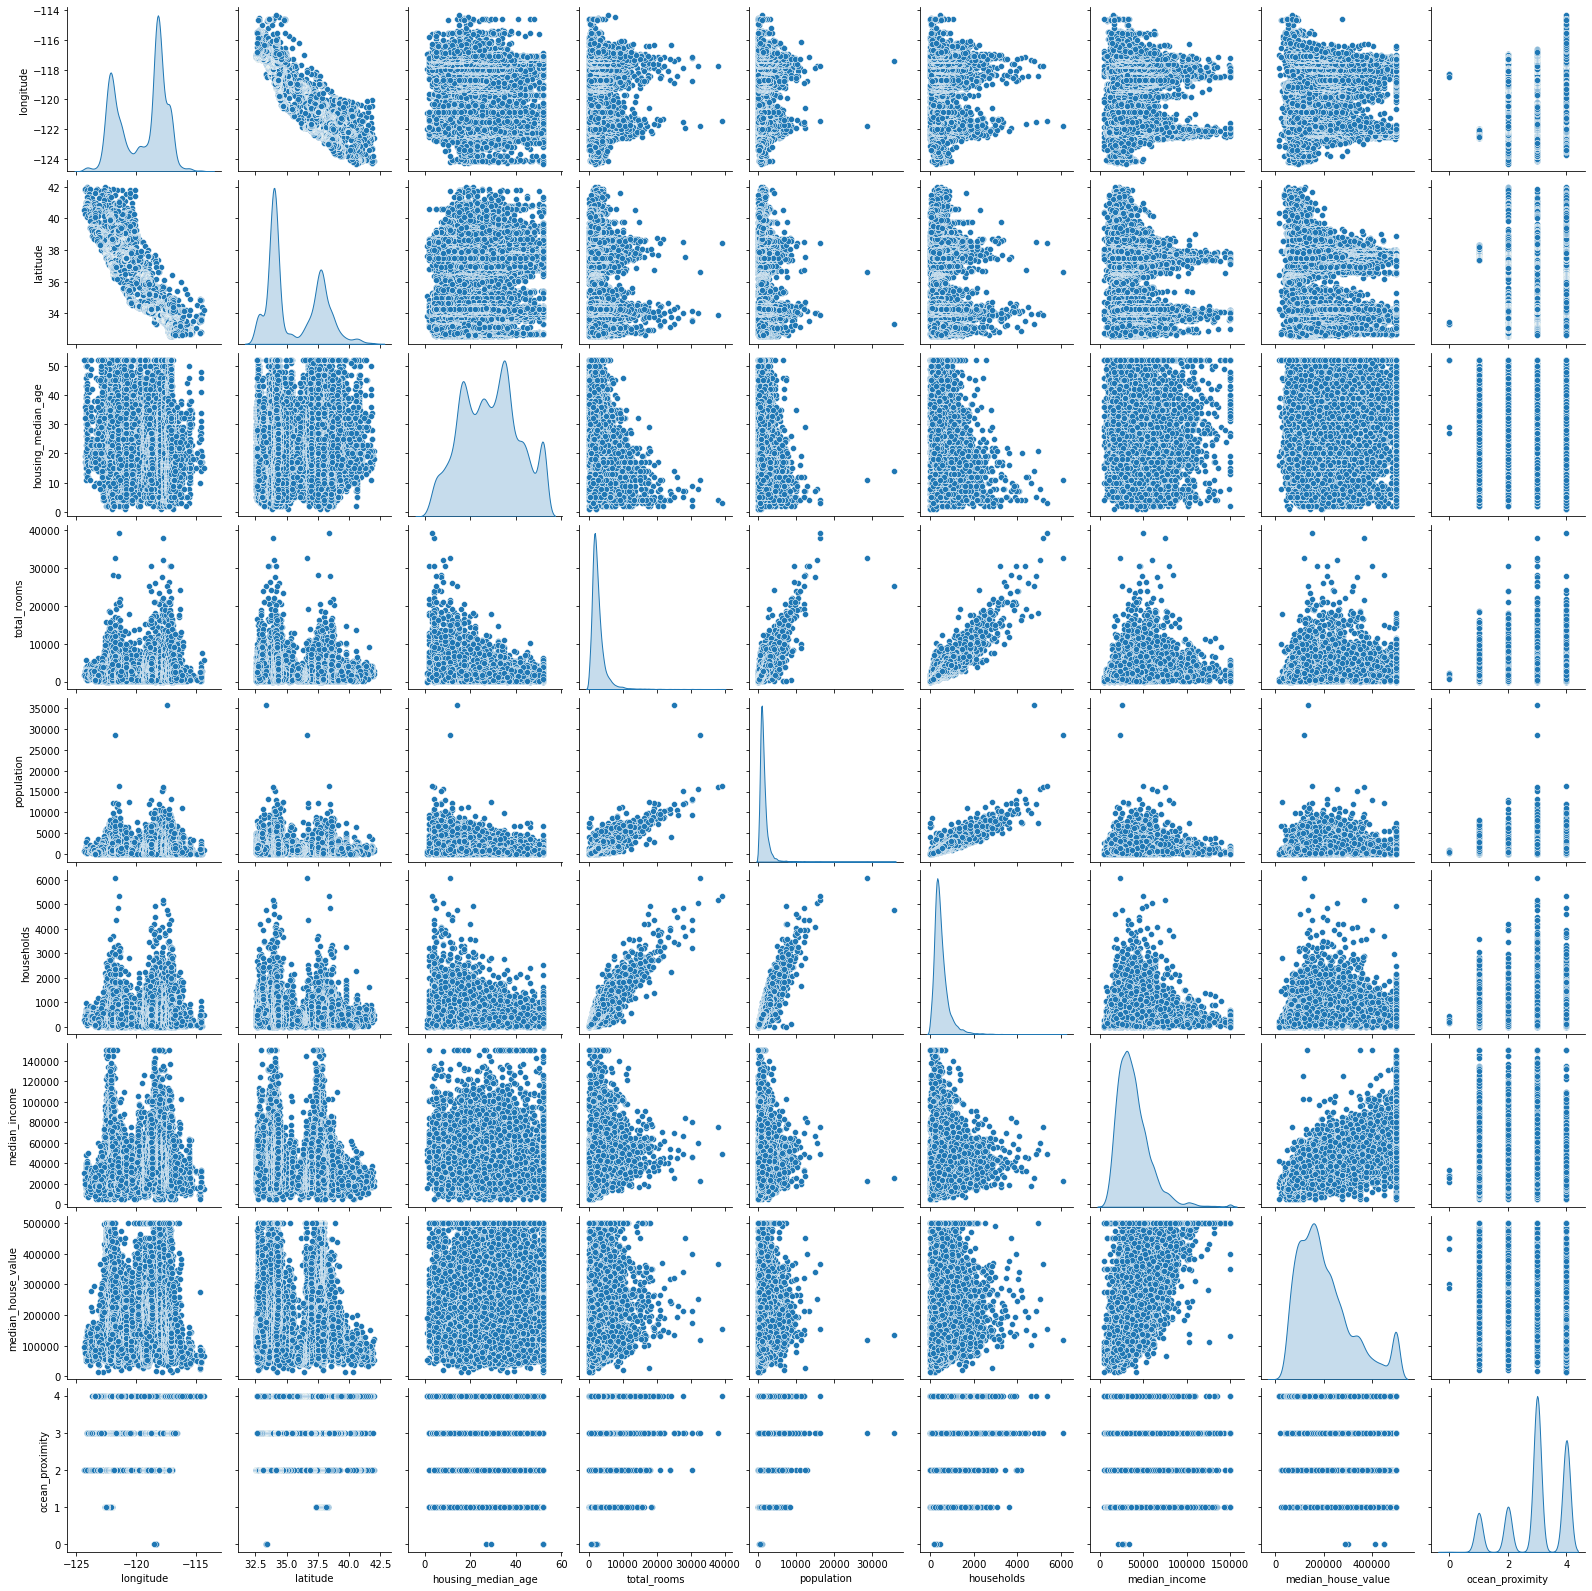

In [16]:
sns.pairplot(cleaned_housing_price[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']], diag_kind='kde')

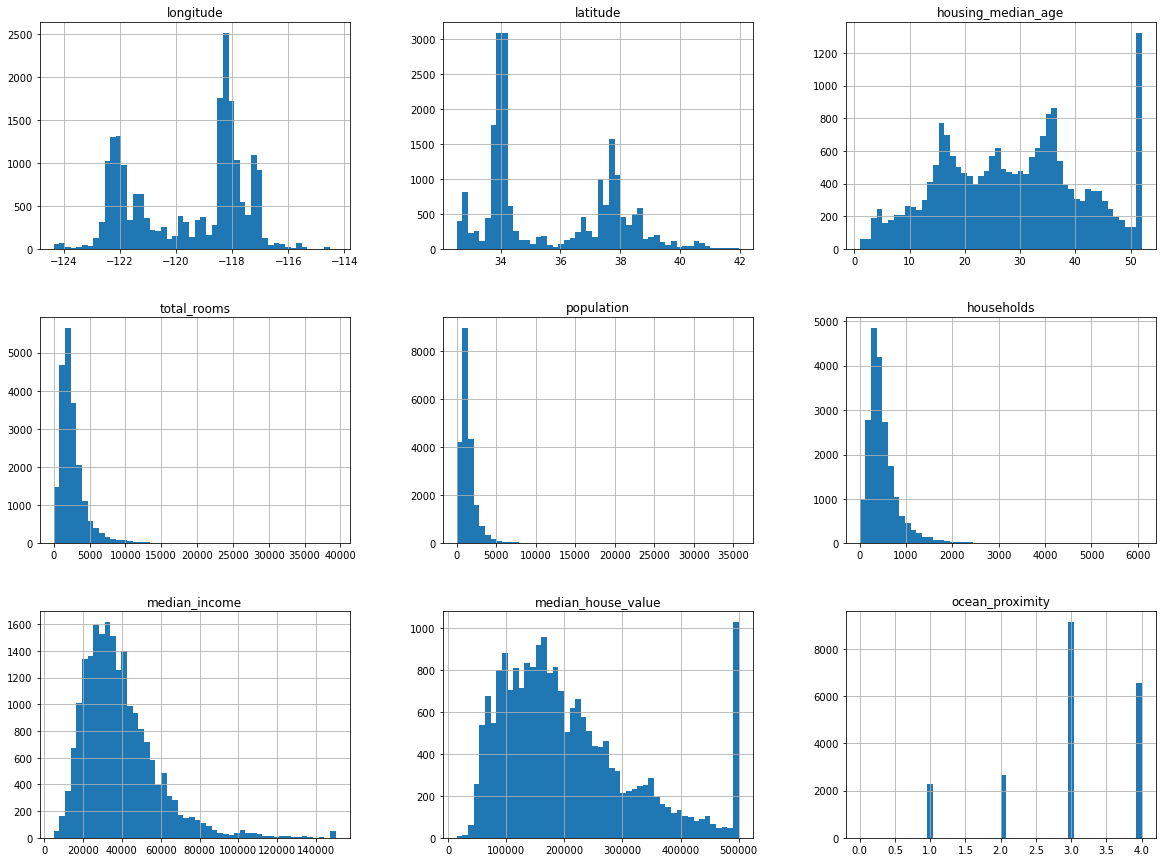

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
cleaned_housing_price.hist(bins=50, figsize=(20,15))
plt.show()

In [18]:
cleaned_housing_price.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.35,-121.80,-118.49,-118.01,-114.31
latitude,20640.0,35.631861,2.135952,32.54,33.93,34.26,37.71,41.95
housing_median_age,20640.0,28.639486,12.585558,1.00,18.00,29.00,37.00,52.00
total_rooms,20640.0,2635.763081,2181.615252,2.00,1447.75,2127.00,3148.00,39320.00
population,20640.0,1425.476744,1132.462122,3.00,787.00,1166.00,1725.00,35682.00
households,20640.0,499.539680,382.329753,1.00,280.00,409.00,605.00,6082.00
median_income,20640.0,38706.710029,18998.217179,4999.00,25634.00,35348.00,47432.50,150001.00
median_house_value,20640.0,206855.816909,115395.615874,14999.00,119600.00,179700.00,264725.00,500001.00
ocean_proximity,20640.0,2.965988,0.943948,0.00,3.00,3.00,4.00,4.00


# Build Model

In [19]:
cleaned_housing_price.corr()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity
longitude,1.000000,-0.924664,-0.108197,0.044568,0.099773,0.055310,-0.015176,-0.045967,0.271730
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.108785,-0.071035,-0.079809,-0.144160,-0.007695
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.296244,-0.302916,-0.119034,0.105623,-0.295012
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.857126,0.918484,0.198050,0.134153,0.031586
population,0.099773,-0.108785,-0.296244,0.857126,1.000000,0.907222,0.004834,-0.024650,0.039415
households,0.055310,-0.071035,-0.302916,0.918484,0.907222,1.000000,0.013033,0.065843,-0.012873
median_income,-0.015176,-0.079809,-0.119034,0.198050,0.004834,0.013033,1.000000,0.688075,-0.163755
median_house_value,-0.045967,-0.144160,0.105623,0.134153,-0.024650,0.065843,0.688075,1.000000,-0.397251
ocean_proximity,0.271730,-0.007695,-0.295012,0.031586,0.039415,-0.012873,-0.163755,-0.397251,1.000000


In [20]:
# Drop target
cleaned_housing_price_data_only = cleaned_housing_price.drop(['median_house_value'], axis=1)
# Drop target, longitude(-0.0459), population(-0.0246), households(0.065843)
X = cleaned_housing_price.drop(['median_house_value', 'longitude', 'population', 'households'], axis=1)
# Target
y = cleaned_housing_price.median_house_value

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Fitting Linear Regression using statsmodel

In [21]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [22]:
# Only use relevant columns: latitude, housing_median_age, total_rooms, median_income, ocean_proximity
train_data_copy = X_train.copy()
train_data_copy['median_house_value'] = y_train
m = ols('median_house_value ~ latitude + housing_median_age + total_rooms + median_income + ocean_proximity', train_data_copy).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     4586.
Date:                Fri, 25 Jun 2021   Prob (F-statistic):               0.00
Time:                        15:50:55   Log-Likelihood:            -2.0874e+05
No. Observations:               16512   AIC:                         4.175e+05
Df Residuals:                   16506   BIC:                         4.175e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.883e+05   1.05

## Fitting Linear Regression using sklearn

In [23]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [24]:
print('Estimated intercept coefficient: {}'.format(lm.intercept_))
print('Somewhat close to the statsmodel score(288300)')

Estimated intercept coefficient: 288255.83133575355
Somewhat close to the statsmodel score(288300)


In [25]:
# The coefficientspd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,latitude,-5140.009020
1,housing_median_age,1185.985651
2,total_rooms,3.141601
3,median_income,3.922964
4,ocean_proximity,-31138.891335


In [26]:
predicted = lm.predict(X_test)
pd.DataFrame({'predicted': predicted, 'price': y_test})[['predicted', 'price']]

,predicted,price
20046,78682.168625,47700.0
3024,127207.647854,45800.0
15663,273051.268311,500001.0
20484,273470.432167,218600.0
9814,231590.757124,278000.0
...,...,...
15362,232939.903222,263300.0
16623,197979.616514,266800.0
18086,407711.948307,500001.0
2144,134528.169393,72300.0


Text(0, 0.5, 'Frequency')

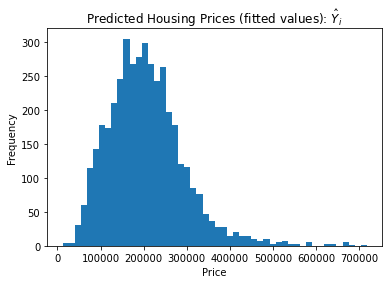

In [27]:
plt.hist(predicted, bins = 50)
plt.title('Predicted Housing Prices (fitted values): $\hat{Y}_i$')
plt.xlabel('Price')
plt.ylabel('Frequency')

C:\Users\chuiw1\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

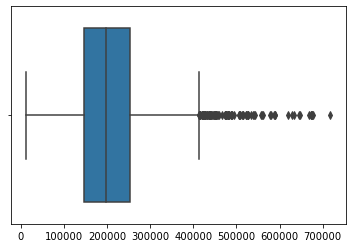

In [28]:
sns.boxplot(predicted)

Text(0.5, 1.0, 'Relationship between predictions and housing price')

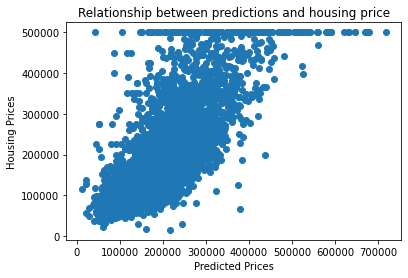

In [29]:
plt.scatter(predicted, y_test)
plt.xlabel("Predicted Prices")
plt.ylabel("Housing Prices")
plt.title("Relationship between predictions and housing price")

### Evaluate Model: the Coefficient of Determination ( 𝑅2 ) and F-Statistic

In [30]:
from sklearn.metrics import r2_score
r2score = r2_score(y_test, predicted)
print("The coefficient of determination (R^2) is " + str(r2score) + " which is close to the statsmodel score(0.581)")

The coefficient of determination (R^2) is 0.5680758915169136 which is close to the statsmodel score(0.581)


In [31]:
# Total data rows
N = len(X_train)
# Number of columns
K = 5

In [32]:
fstat = (r2score/(1-r2score))*((N-K-1)/K)
print("The f-statistic is " + str(fstat) + ", which is not very close to the statsmodel score(4586)")

The f-statistic is 4341.809350864403, which is not very close to the statsmodel score(4586)


# Different Models Using Columns [latitude, housing_median_age, total_rooms, median_income, ocean_proximity]

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score   

In [34]:
def display_statistics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    print("rmse: " + str(rmse))
    
    r2score = r2_score(actual, predicted)
    print("The coefficient of determination (R^2): " + str(r2score))
    
    fstat = (r2score/(1-r2score))*((N-K-1)/K)
    print("The f-statistic: " + str(fstat))

In [35]:
def display_scores(model, data, actual):
    scores = cross_val_score(model, data, actual,
                         scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
   
    print("Scores:", rmse_scores)
    print("Mean:", rmse_scores.mean())
    print("Standard deviation:", rmse_scores.std()) 

## Linear Regression

In [36]:
display_statistics(y_test, predicted)
print()
display_scores(lm, X_test, y_test)

rmse: 75232.78737857137
The coefficient of determination (R^2): 0.5680758915169136
The f-statistic: 4341.809350864403

Scores: [71705.23569563 77916.42696044 77297.42762523 78029.11195844
 77044.57499924 67539.82819268 72974.68479171 82011.36726594
 74410.23386636 73120.50811059]
Mean: 75204.9399466257
Standard deviation: 3877.765387144809


## Decision Tree Regression

In [37]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

display_statistics(y_test, tree_model.predict(X_test))
print()
display_scores(tree_model, X_test, y_test)

rmse: 84363.44790341306
The coefficient of determination (R^2): 0.45687251382342886
The f-statistic: 2776.930980332631

Scores: [84368.27965345 87223.93722899 91261.4105164  99879.03308956
 90747.46282277 80703.44034681 77548.04353887 98409.16674938
 84532.59450956 90968.5731318 ]
Mean: 88564.19415875919
Standard deviation: 6793.927800635414


## RandomForestRegressor

In [38]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)

display_statistics(y_test, forest_model.predict(X_test))
print()
display_scores(forest_model, X_test, y_test)

rmse: 62848.43175205822
The coefficient of determination (R^2): 0.698573083725699
The f-statistic: 7650.708478524462

Scores: [63527.5439523  64697.28688156 68572.84935607 72537.56643755
 70121.63801152 56206.20412017 60590.02482722 70172.33745912
 66713.36437319 67323.8803254 ]
Mean: 66046.2695744113
Standard deviation: 4679.659571994518


## SVR

In [39]:
from sklearn.svm import SVR

svm_model = SVR(kernel="linear")
svm_model.fit(X_train, y_train)

display_statistics(y_test, svm_model.predict(X_test))
print()
display_scores(svm_model, X_test, y_test)

rmse: 81237.3469532933
The coefficient of determination (R^2): 0.4963781041191456
The f-statistic: 3253.7175423083463

Scores: [80163.29386994 85811.54326574 83157.47724126 86419.97263568
 84794.37384003 72529.59386974 80182.8056402  87565.83388811
 82067.71717157 80464.02403442]
Mean: 82315.66354566837
Standard deviation: 4146.353287189571


# Fine-tune the RandomForestRegressor Model

## Using GridSearchCV

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 5]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_model1 = RandomForestRegressor(random_state=42)

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_model1, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 5],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [41]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [42]:
grid_search.best_estimator_

RandomForestRegressor(max_features=2, n_estimators=30, random_state=42)

In [43]:
forest_model1_best_estimator = grid_search.best_estimator_
display_statistics(y_test, forest_model1_best_estimator.predict(X_test))
print()
display_scores(forest_model1_best_estimator, X_test, y_test)

rmse: 62639.949122760525
The coefficient of determination (R^2): 0.7005695709312594
The f-statistic: 7723.731601865151

Scores: [60984.45212564 65820.12115338 69735.48617108 71505.26363746
 69598.1865384  57828.02268077 60733.45228523 70128.021386
 67700.33735773 67102.69056577]
Mean: 66113.60339014587
Standard deviation: 4448.967553369915


In [44]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

70983.22785268408 {'max_features': 2, 'n_estimators': 3}
63903.717779842635 {'max_features': 2, 'n_estimators': 10}
61973.13312781692 {'max_features': 2, 'n_estimators': 30}
71157.32504375935 {'max_features': 4, 'n_estimators': 3}
64544.34531263899 {'max_features': 4, 'n_estimators': 10}
62357.616922453984 {'max_features': 4, 'n_estimators': 30}
71388.31484062113 {'max_features': 5, 'n_estimators': 3}
64821.94339568606 {'max_features': 5, 'n_estimators': 10}
62662.80571178656 {'max_features': 5, 'n_estimators': 30}
71039.95119950893 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
64851.659519831366 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
71428.73766469372 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
65267.377935472854 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
73816.53069061383 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
67723.26783253592 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}


In [45]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.073414,0.013176,0.005788,0.000987,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-5.174596e+09,-4.927856e+09,...,-5.038619e+09,9.452905e+07,10,-1.346916e+09,-1.293148e+09,-1.293336e+09,-1.324770e+09,-1.292317e+09,-1.310097e+09,2.215966e+07
1,0.211283,0.005314,0.013161,0.002920,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-4.117248e+09,-4.031521e+09,...,-4.083685e+09,2.816631e+07,4,-7.623138e+08,-7.436272e+08,-7.318847e+08,-7.512006e+08,-7.527837e+08,-7.483620e+08,1.016053e+07
2,0.614328,0.003233,0.028517,0.001021,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-3.897922e+09,-3.794043e+09,...,-3.840669e+09,6.210594e+07,1,-5.917636e+08,-5.956772e+08,-5.769774e+08,-5.854334e+08,-5.957067e+08,-5.891117e+08,7.133047e+06
3,0.104565,0.001812,0.004988,0.000621,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-5.127295e+09,-5.139625e+09,...,-5.063365e+09,7.945362e+07,12,-1.264626e+09,-1.286910e+09,-1.228545e+09,-1.293488e+09,-1.291736e+09,-1.273061e+09,2.453804e+07
4,0.345241,0.001815,0.011762,0.001153,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-4.273223e+09,-4.250872e+09,...,-4.165973e+09,1.262494e+08,5,-7.553511e+08,-7.314077e+08,-7.342722e+08,-7.349360e+08,-7.490922e+08,-7.410119e+08,9.439116e+06
5,1.057001,0.052098,0.029523,0.001352,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-3.936025e+09,-3.893697e+09,...,-3.888472e+09,8.477089e+07,2,-5.987655e+08,-5.906094e+08,-5.852290e+08,-5.867034e+08,-5.987351e+08,-5.920085e+08,5.778690e+06
6,0.123291,0.001337,0.004779,0.000741,5,3,NaN,"{'max_features': 5, 'n_estimators': 3}",-5.203344e+09,-5.193481e+09,...,-5.096291e+09,1.428419e+08,13,-1.282552e+09,-1.289647e+09,-1.291393e+09,-1.246734e+09,-1.290889e+09,-1.280243e+09,1.705467e+07
7,0.413768,0.007427,0.011193,0.000965,5,10,NaN,"{'max_features': 5, 'n_estimators': 10}",-4.183477e+09,-4.297916e+09,...,-4.201884e+09,9.310827e+07,6,-7.578620e+08,-7.400590e+08,-7.549359e+08,-7.563826e+08,-7.544531e+08,-7.527385e+08,6.450862e+06
8,1.229341,0.010990,0.029933,0.001098,5,30,NaN,"{'max_features': 5, 'n_estimators': 30}",-3.898781e+09,-3.991675e+09,...,-3.926627e+09,7.957795e+07,3,-6.006777e+08,-5.964589e+08,-5.963006e+08,-6.046267e+08,-6.045413e+08,-6.005210e+08,3.670351e+06
9,0.101177,0.002219,0.005186,0.000748,2,3,False,"{'bootstrap': False, 'max_features': 2, 'n_est...",-5.087445e+09,-4.902536e+09,...,-5.046675e+09,1.819380e+08,11,-6.610476e+03,-4.205887e+04,-0.000000e+00,-8.964589e+02,-0.000000e+00,-9.913160e+03,1.626097e+04


## Using RandomizedSearchCV

In [46]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=5),
    }

forest_model2 = RandomForestRegressor(random_state=42)

rnd_search = RandomizedSearchCV(forest_model2, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D3E0852100>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D3C7523CD0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [47]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

61235.61181001217 {'max_features': 3, 'n_estimators': 180}
64302.06642122953 {'max_features': 1, 'n_estimators': 15}
61504.51418726245 {'max_features': 3, 'n_estimators': 72}
63308.16610978988 {'max_features': 1, 'n_estimators': 21}
61385.88009442614 {'max_features': 3, 'n_estimators': 122}
61507.26085325726 {'max_features': 3, 'n_estimators': 75}
61441.794209590924 {'max_features': 3, 'n_estimators': 88}
61613.69861005116 {'max_features': 1, 'n_estimators': 100}
61623.82824288702 {'max_features': 4, 'n_estimators': 152}
61297.35598039831 {'max_features': 3, 'n_estimators': 150}


In [48]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.14026172, 0.08721476, 0.09393692, 0.5042711 , 0.1743155 ])

In [49]:
final_model = rnd_search.best_estimator_

#X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)

display_statistics(y_test, final_predictions)
print()
display_scores(final_model, X_test, y_test)

rmse: 61969.32432014822
The coefficient of determination (R^2): 0.7069466692871096
The f-statistic: 7963.643815183403

Scores: [63035.57196213 63754.40380951 68075.17985704 71075.73609907
 68613.48706063 55652.9230227  59863.25467601 69960.07861053
 66735.24270172 66343.69816966]
Mean: 65310.95759690025
Standard deviation: 4550.220901468609


In [50]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([59431.69786676, 64407.04621441])

In [51]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(59431.69786675991, 64407.046214413676)

In [52]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(59432.457980764295, 64406.34480977895)